In [1]:
# Instacart recommendation engine
# see https://github.com/hjhuney/Instacart/blob/master/Instacart.ipynb

# Imports

In [2]:
# standard libraries
import pandas as pd
import numpy as np

# visualization library
#import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns

# modeling libaries
from sklearn.metrics.pairwise import cosine_similarity

# Load Data Functions

In [12]:
# function to print out df.info() and df.head() cleanly
def print_info(df):
    print(("=" * 10) + " Info " + ("=" * 10) + "\n")
    print(df.info())
    print("\n" + ("=" * 10) + " First 5 Rows " + ("=" * 10) + "\n")
    print(df.head())

# DataFrames

Loading all datasets, along with info (row data, memory usage), and first 5 rows of data. 

In [13]:
products = pd.read_csv('./data/products.csv')

In [14]:
# product dictionaries for future usage in mapping
product_dict = dict(zip(products['product_name'], products['product_id']))
product_dict_inv = dict([v,k] for k,v in product_dict.items())

In [15]:
orders = pd.read_csv('./data/orders.csv')
orders['days_since_prior_order'] = orders['days_since_prior_order'].fillna(-99)
orders['days_since_prior_order'] = orders['days_since_prior_order'].astype('int16')

In [16]:
aisles = pd.read_csv('./data/aisles.csv')

In [17]:
departments = pd.read_csv('./data/departments.csv')

In [18]:
prior = pd.read_csv('./data/order_products__prior.csv')

In [19]:
train = pd.read_csv('./data/order_products__train.csv')

In [20]:
#test = downcast_df('./data/order_products__test.csv')

# Merge Prior, Order, and Product DataFrames

In [21]:
prior_merge1 = pd.merge(prior, products, on="product_id", how="left")
df = pd.merge(prior_merge1, orders, on="order_id", how="left")
df = df.drop(['eval_set'], axis=1)
df['days_since_prior_order'] = df['days_since_prior_order'].fillna(-1).astype('int16')
product_count = df.groupby('product_id').size()
df['count'] = df['product_id'].map(product_count).astype('uint32')

In [22]:
df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,count
0,2,33120,1,1,Organic Egg Whites,86,16,202279,3,5,9,8,19400
1,2,28985,2,1,Michigan Organic Kale,83,4,202279,3,5,9,8,67449
2,2,9327,3,0,Garlic Powder,104,13,202279,3,5,9,8,6299
3,2,45918,4,1,Coconut Butter,19,13,202279,3,5,9,8,744
4,2,30035,5,0,Natural Sweetener,17,13,202279,3,5,9,8,569


In [23]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 13 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   order_id                int64 
 1   product_id              int64 
 2   add_to_cart_order       int64 
 3   reordered               int64 
 4   product_name            object
 5   aisle_id                int64 
 6   department_id           int64 
 7   user_id                 int64 
 8   order_number            int64 
 9   order_dow               int64 
 10  order_hour_of_day       int64 
 11  days_since_prior_order  int16 
 12  count                   uint32
dtypes: int16(1), int64(10), object(1), uint32(1)
memory usage: 5.1 GB


# Data Exploration

Exploration of various attributes of product and order data. 

## Time of Day

In [24]:
time_of_day = orders['order_hour_of_day'].value_counts()
time_of_day = time_of_day.reset_index()
time_of_day['pct_of_total'] = np.round((time_of_day['order_hour_of_day'] / time_of_day['order_hour_of_day'].sum()*100), 2)

<function matplotlib.pyplot.show(close=None, block=None)>

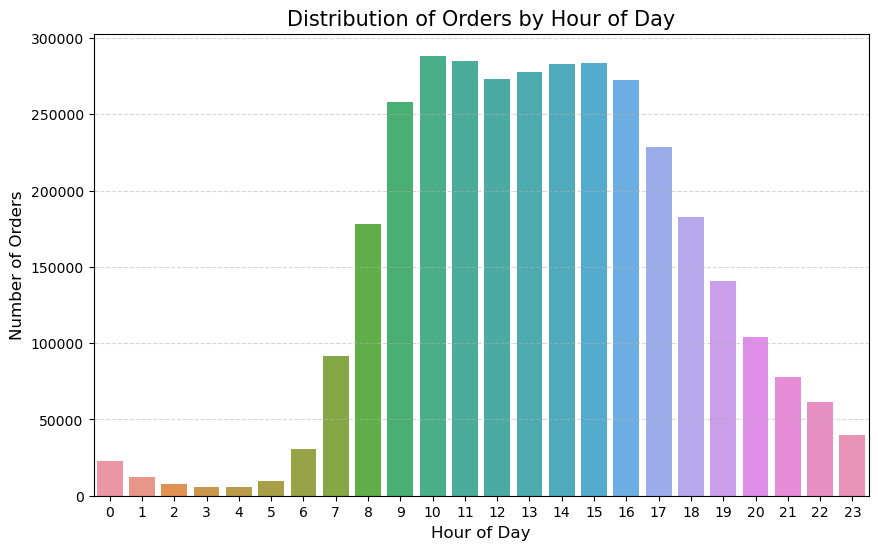

In [25]:
#Now, we will print a graph with how orders have been distributed over hours
orders_per_hour = orders['order_hour_of_day'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=orders_per_hour.index, y=orders_per_hour.values)

plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.title('Distribution of Orders by Hour of Day', fontsize=15)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.5)
del (orders_per_hour)
plt.show

From this, we can see that most orders come in the 7am - 9pm timeframe, with heaviest demand from 9am - 5pm. 

## Orders by Day of Week

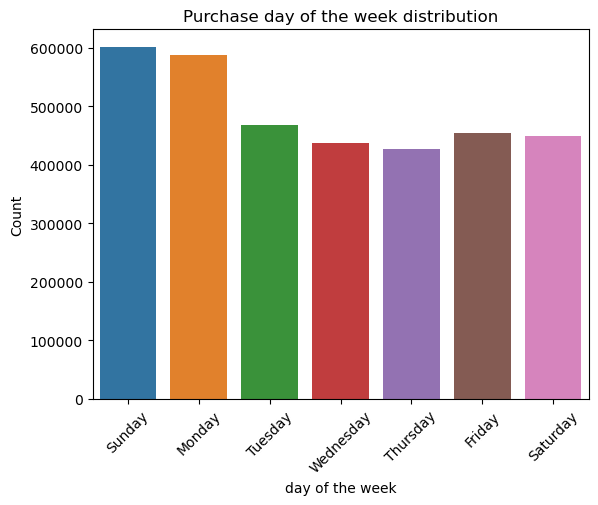

In [26]:
# The figure looks so so a trick to have the name of the days using a list (careful 0 is sunday)
# Remember, spend time making your visualizations as nice as possible
d_o_w_list = ['Sunday', 'Monday', 'Tuesday','Wednesday','Thursday', 'Friday', 'Saturday']
fig, ax = plt.subplots()
sns.countplot(orders, x='order_dow')
plt.title("Purchase day of the week distribution")
plt.xlabel("day of the week")
plt.ylabel("Count")
ax.set_xticklabels(d_o_w_list, rotation=45)
plt.show()

From this chart, we can see that orders are spread out reasonably well over the week, but Sunday and Monday are the busiest days, account for ~ 34% of all orders. Differences between Tuesday thru Saturday appear to be neglible, so we can think of the week in terms of two categories: Sunday + Monday (peak days) and Tues - Sat.   

## Days Since Last Order

In [27]:
days_since_prior = orders['days_since_prior_order'].value_counts()
days_since_prior = days_since_prior.reset_index()
days_since_prior.columns = ['days_since_prior_order', 'count']
days_since_prior = days_since_prior.sort_values(by=['days_since_prior_order'])
days_since_prior = days_since_prior.drop(6, axis=0)
days_since_prior = days_since_prior.reset_index(drop=True)
days_since_prior['pct_of_total'] = np.round((days_since_prior['count'] / days_since_prior['count'].sum()*100), 2)

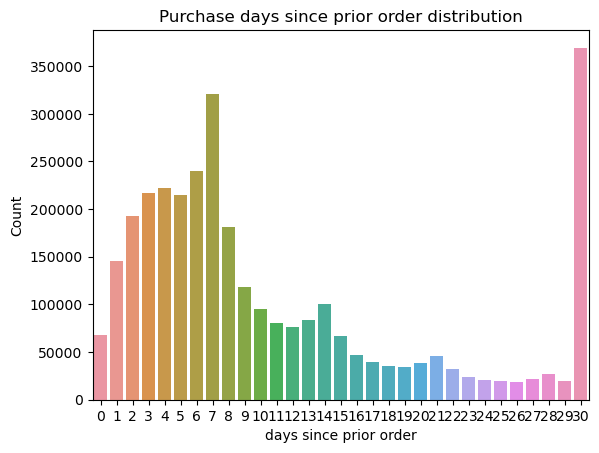

In [28]:
# The figure looks so so a trick to have the name of the days using a list (careful 0 is sunday)
# Remember, spend time making your visualizations as nice as possible

fig, ax = plt.subplots()
sns.barplot(days_since_prior, x="days_since_prior_order", y = "count")
plt.title("Purchase days since prior order distribution")
plt.xlabel("days since prior order")
plt.ylabel("Count")

plt.show()

The most interesting observation here is that ~ 10% of customers reorder exactly 7 days after their prior order. Approximately 50% of customers reorder within 7 days. 

## Orders by Department

In [29]:
dept_stats = df['department_id'].value_counts().reset_index()
dept_stats.columns = ['department_id', 'freq']
dept_stats = pd.merge(dept_stats, departments, on='department_id', how='left')
dept_stats['pct_orders'] = np.round((dept_stats['freq'] / dept_stats['freq'].sum()) * 100,2)

In [30]:
dept_stats.columns

Index(['department_id', 'freq', 'department', 'pct_orders'], dtype='object')

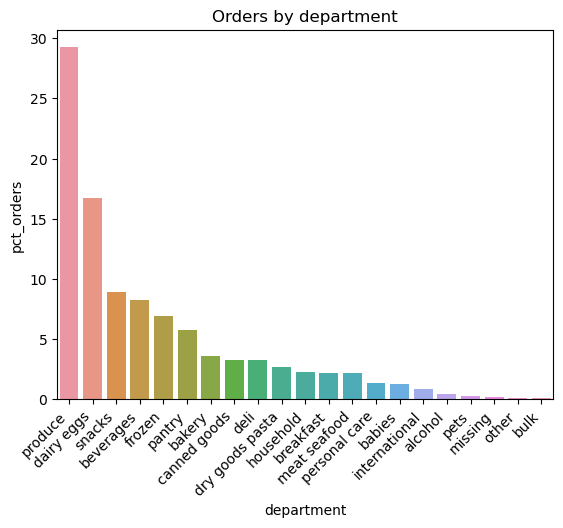

In [35]:
chart_title = "Orders by Department"
x_label = "department"
y_label = 'freq'


fig, ax = plt.subplots()
sns.barplot(dept_stats, x= "department", y = "pct_orders")
plt.title("Orders by department")
plt.xlabel("department")
plt.ylabel("pct_orders")
ax.set_xticklabels(dept_stats.department, rotation=45, ha="right")
plt.show()


Produce dominates this category, accounting for roughly 29% of all items purchased. Dairy + eggs are 2nd most popular department, accounting for ~ 17% of items purchased. 

## Item Order Frequency

In [36]:
products['count'] = products['product_id'].map(product_count).fillna(0).astype('uint32')

In [37]:
bin_labels = ['0-5', '6-20', '21-50','51-100','101-500','501-2500','2500-10000', '10001-50000', '50000+']
bins = [0, 6, 21, 51, 101, 501, 2501,10001, 50001, 500000]

products['count_bin'] = pd.cut(products['count'], bins, labels=bin_labels)

In [38]:
prod_count_bins = pd.DataFrame(products['count_bin'].value_counts())
prod_count_bins = prod_count_bins.reset_index()
prod_count_bins.columns = ['bin', 'count']
prod_count_bins['pct_total'] = np.round((prod_count_bins['count'] / prod_count_bins['count'].sum()) * 100,2)
c

,bin,count,pct_total
0,101-500,11614,23.38
1,6-20,10473,21.08
2,21-50,8689,17.49
3,51-100,6397,12.88
4,501-2500,5997,12.07
5,0-5,4234,8.52
6,2500-10000,1781,3.59
7,10001-50000,432,0.87
8,50000+,60,0.12


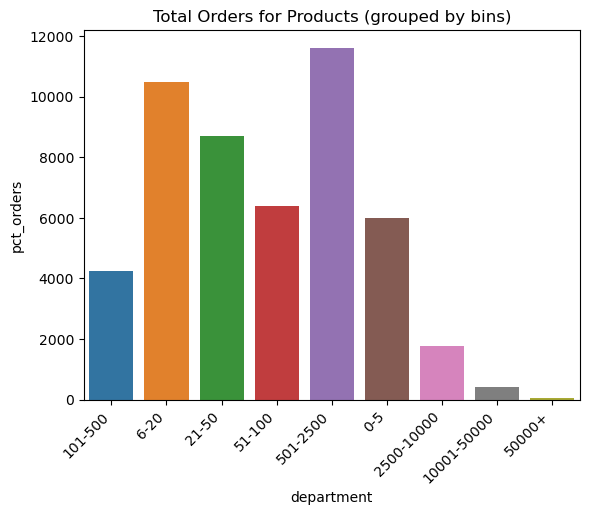

In [41]:
chart_title = "Total Orders for Products (grouped by bins)"
x_label = "bin:O"
y_label = 'count:Q'
pct_total = 'pct_total:Q'

fig, ax = plt.subplots()
sns.barplot(prod_count_bins, x= "bin", y = "count")
plt.title(chart_title)
plt.xlabel("department")
plt.ylabel("pct_orders")
ax.set_xticklabels(prod_count_bins.bin, rotation=45, ha="right")
plt.show()

What this visualization tells us is that the majority of products are ordered between 0 - 100 times. Products ordered more than 10,000 times are rare (about 1% of total products) and even products ordered more than 2,500 times make up a small percentage (~ 5%) of the total number of products.

Items ordered 5 or fewer times account for 8.5% of total products and products ordered fewer than 20 times account for roughly 30% of products. A sizable percentage (~ 23%) of products are ordered between 100 and 500 times. 

## Most Popular Products

In [42]:
# 20 most commonly ordered products
df['product_name'].value_counts()[:20]

product_name
Banana                      472565
Bag of Organic Bananas      379450
Organic Strawberries        264683
Organic Baby Spinach        241921
Organic Hass Avocado        213584
Organic Avocado             176815
Large Lemon                 152657
Strawberries                142951
Limes                       140627
Organic Whole Milk          137905
Organic Raspberries         137057
Organic Yellow Onion        113426
Organic Garlic              109778
Organic Zucchini            104823
Organic Blueberries         100060
Cucumber Kirby               97315
Organic Fuji Apple           89632
Organic Lemon                87746
Apple Honeycrisp Organic     85020
Organic Grape Tomatoes       84255
Name: count, dtype: int64

In [43]:
# total number of orders
num_orders = orders.shape[0]

# top 30 products DF
top_prods = df['product_name'].value_counts()[:30]
top_prods = pd.DataFrame(top_prods).reset_index()
top_prods.columns = ['index', 'count']
top_prods['product_num'] = top_prods['index'].map(product_dict)
top_prods['Pct_of_Baskets'] = (top_prods['count'] / num_orders) * 100

In [44]:
top_prods.head()

,index,count,product_num,Pct_of_Baskets
0,Banana,472565,24852,13.813316
1,Bag of Organic Bananas,379450,13176,11.091517
2,Organic Strawberries,264683,21137,7.736819
3,Organic Baby Spinach,241921,21903,7.071474
4,Organic Hass Avocado,213584,47209,6.243169


In [49]:
top_prods_order_list

['Banana',
 'Bag of Organic Bananas',
 'Organic Strawberries',
 'Organic Baby Spinach',
 'Organic Hass Avocado',
 'Organic Avocado',
 'Large Lemon',
 'Strawberries',
 'Limes',
 'Organic Whole Milk',
 'Organic Raspberries',
 'Organic Yellow Onion',
 'Organic Garlic',
 'Organic Zucchini',
 'Organic Blueberries',
 'Cucumber Kirby',
 'Organic Fuji Apple',
 'Organic Lemon',
 'Apple Honeycrisp Organic',
 'Organic Grape Tomatoes',
 'Seedless Red Grapes',
 'Organic Cucumber',
 'Honeycrisp Apple',
 'Organic Baby Carrots',
 'Organic Half & Half',
 'Sparkling Water Grapefruit',
 'Organic Large Extra Fancy Fuji Apple',
 'Yellow Onions',
 'Organic Gala Apples',
 'Organic Baby Arugula']

In [45]:
top_prods_order_list = top_prods['index'].tolist()

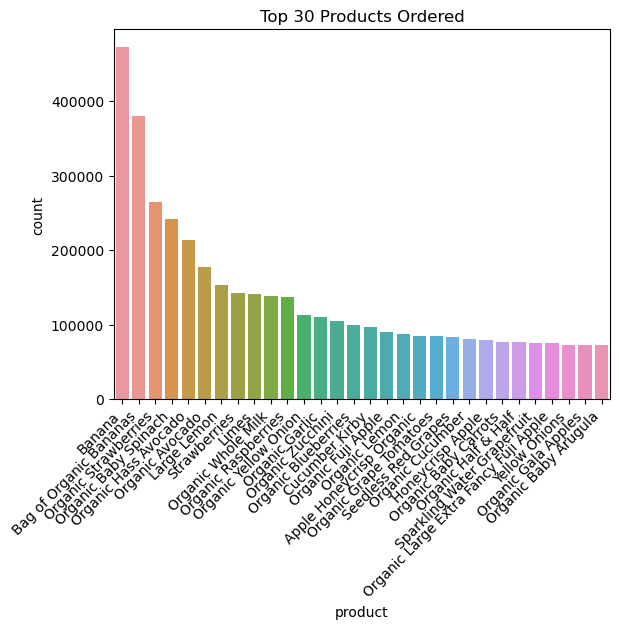

In [50]:
chart_title = "Top 30 Products Ordered"
x_label = "index:O"
y_label = 'count:Q'
pct_of_baskets = 'Pct_of_Baskets:Q'
product_num = 'product_num:O'

fig, ax = plt.subplots()
sns.barplot(top_prods, x= "index", y = "count")
plt.title(chart_title)
plt.xlabel("product")
plt.ylabel("count")
ax.set_xticklabels(top_prods_order_list, rotation=45, ha="right")
plt.show()

Regular bananas are ordered in a whopping 13% of baskets, while organic bananas are ordered in 11%. There's a significant dropoff by the time we reach the 30th most popular item (organic baby arugla), which is in 2% of baskets. Produce items dominate the top 30 products. 

In [51]:
# create dictionary for market basket % for every product

all_prods = df['product_name'].value_counts()
all_prods = pd.DataFrame(all_prods).reset_index()
all_prods.columns = ['index', 'count']
all_prods['product_id'] = all_prods['index'].map(product_dict)
all_prods['pct_pop_orders'] = (all_prods['count'] / num_orders) * 100

pct_order_dict = pd.Series(all_prods['pct_pop_orders'].values,index=all_prods['product_id']).to_dict()

# Associations

Next we'll explore associations between items. We'll look at various items purchased and what other items tend to be purchased alongside those items. 

## Items Most Frequently Ordered with Organic Strawberries

Let's start with one of the most popular items: organic strawberries. 

In [52]:
ords_org_strawberries = df[df['product_id'] == 21137]['order_id'].tolist()
# ords_org_strawberries[:10]

In [53]:
org_strawberry_df = df[df['order_id'].isin(ords_org_strawberries)]

In [54]:
# top 30 items ordered with organic strawberries
num_org_strawb = org_strawberry_df['product_name'].value_counts()[0]
top_items_org_strawb = org_strawberry_df['product_name'].value_counts()[1:31]
top_items_org_strawb

product_name
Bag of Organic Bananas                  61628
Banana                                  56156
Organic Hass Avocado                    40794
Organic Baby Spinach                    38134
Organic Raspberries                     33863
Organic Avocado                         23984
Organic Whole Milk                      23813
Organic Blueberries                     23756
Limes                                   18999
Organic Yellow Onion                    16651
Organic Cucumber                        16555
Large Lemon                             16305
Apple Honeycrisp Organic                15870
Organic Garlic                          15627
Organic Grape Tomatoes                  15573
Organic Zucchini                        15320
Organic Lemon                           15152
Organic Large Extra Fancy Fuji Apple    15113
Seedless Red Grapes                     13935
Organic Whole String Cheese             13513
Organic Gala Apples                     13298
Organic Baby Carrots 

In [55]:
top_items_org_strawb_df = pd.DataFrame(top_items_org_strawb)
top_items_org_strawb_df = top_items_org_strawb_df.reset_index()
top_items_org_strawb_df.columns = ['index', 'count']
top_items_org_strawb_df['pct_orders'] = np.round((top_items_org_strawb_df['count'] / num_org_strawb) * 100,2)
top_items_org_strawb_df['product_id'] = top_items_org_strawb_df['index'].map(product_dict)
top_items_org_strawb_df['pop_pct_orders'] = top_items_org_strawb_df['product_id'].map(pct_order_dict)
top_items_org_strawb_df['purchase_ratio'] = np.round(top_items_org_strawb_df['pct_orders'] / top_items_org_strawb_df['pop_pct_orders'], 2)
top_items_org_strawb_df.head(20)

,index,count,pct_orders,product_id,pop_pct_orders,purchase_ratio
0,Bag of Organic Bananas,61628,23.28,13176,11.091517,2.10
1,Banana,56156,21.22,24852,13.813316,1.54
2,Organic Hass Avocado,40794,15.41,47209,6.243169,2.47
3,Organic Baby Spinach,38134,14.41,21903,7.071474,2.04
4,Organic Raspberries,33863,12.79,27966,4.006246,3.19
5,Organic Avocado,23984,9.06,47766,5.168393,1.75
6,Organic Whole Milk,23813,9.00,27845,4.031033,2.23
7,Organic Blueberries,23756,8.98,39275,2.924805,3.07
8,Limes,18999,7.18,26209,4.110599,1.75
9,Organic Yellow Onion,16651,6.29,22935,3.315500,1.90


In [61]:
org_straw_order_list = top_items_org_strawb_df['index'].tolist()

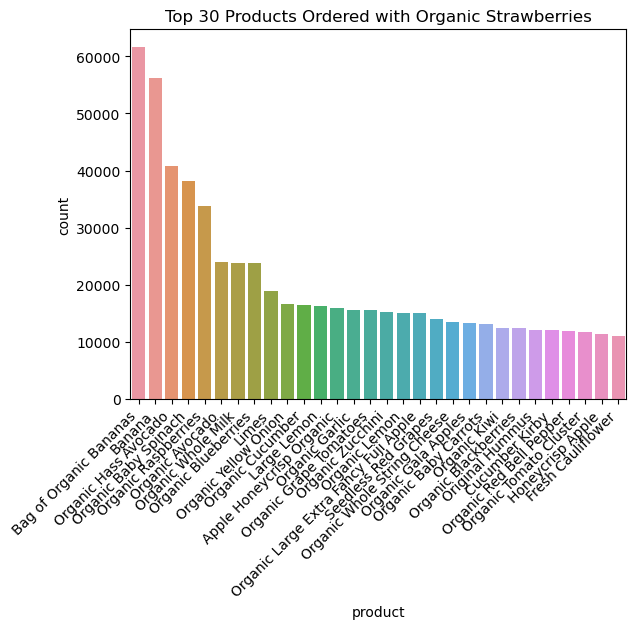

In [62]:
chart_title = "Top 30 Products Ordered with Organic Strawberries"
x_label = "index:O"
y_label = 'count:Q'
pct_of_orders = 'pct_orders:Q'
product_num = 'product_id:O'
multiple = 'purchase_ratio:Q'

fig, ax = plt.subplots()
sns.barplot(top_items_org_strawb_df, x= "index", y = "count")
plt.title(chart_title)
plt.xlabel("product")
plt.ylabel("count")
ax.set_xticklabels(org_straw_order_list, rotation=45, ha="right")
plt.show()

## Items Most Frequently Ordered with Honeycrisp Apples

In [65]:
# find top n items ordered with any particular product by product_id
def top_n_items(df, product_id, n):
    orders = df[df['product_id'] == product_id]['order_id'].tolist()
    orders_with_item = df[df['order_id'].isin(orders)]

    # top 30 items ordered with organic strawberries
    num_of_main_item = orders_with_item['product_name'].value_counts()[0]
    top_items_with_item = orders_with_item['product_name'].value_counts()[1:n+1]

    top_items_with_item = pd.DataFrame(top_items_with_item)
    top_items_with_item = top_items_with_item.reset_index()
    top_items_with_item.columns = ['index', 'count']
    top_items_with_item['pct_orders'] = np.round((top_items_with_item['count'] / num_of_main_item) * 100, 2)
    top_items_with_item['product_id'] = top_items_with_item['index'].map(product_dict)

    top_items_order_list = top_items_with_item['index'].tolist()
    
    return top_items_with_item

In [66]:
# top 10 items ordered with honeycrisp apples
honeycrisp_df = top_n_items(df, 45066, 20)
honeycrisp_df['pop_pct_orders'] = honeycrisp_df['product_id'].map(pct_order_dict)
honeycrisp_df['purchase_ratio'] = np.round(honeycrisp_df['pct_orders'] / honeycrisp_df['pop_pct_orders'], 2)
honeycrisp_df

,index,count,pct_orders,product_id,pop_pct_orders,purchase_ratio
0,Banana,28408,35.61,24852,13.813316,2.58
1,Organic Strawberries,11465,14.37,21137,7.736819,1.86
2,Bag of Organic Bananas,11137,13.96,13176,11.091517,1.26
3,Organic Avocado,11046,13.85,47766,5.168393,2.68
4,Organic Baby Spinach,10170,12.75,21903,7.071474,1.80
5,Large Lemon,9485,11.89,47626,4.462242,2.66
6,Organic Hass Avocado,8100,10.15,47209,6.243169,1.63
7,Strawberries,7536,9.45,16797,4.178531,2.26
8,Limes,6993,8.77,26209,4.110599,2.13
9,Cucumber Kirby,6518,8.17,49683,2.844567,2.87


In [68]:
honeycrisp_order_list = honeycrisp_df['index'].tolist()

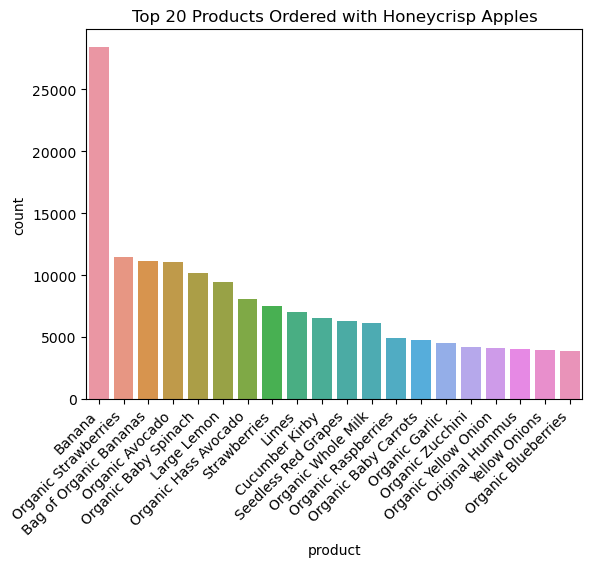

In [69]:
chart_title = "Top 20 Products Ordered with Honeycrisp Apples"
x_label = "index:O"
y_label = 'count:Q'
pct_of_orders = 'pct_orders:Q'
product_num = 'product_id:O'
multiple = 'purchase_ratio:Q'
sort_list = honeycrisp_df['index'].tolist()


fig, ax = plt.subplots()
sns.barplot(honeycrisp_df, x= "index", y = "count")
plt.title(chart_title)
plt.xlabel("product")
plt.ylabel("count")
ax.set_xticklabels(honeycrisp_order_list, rotation=45, ha="right")
plt.show()

## Items Most Frequently Ordered with Organic Turkey Burgers

In [70]:
# top 20 items ordered with honeycrisp apples
org_turkey_burger_df = top_n_items(df, 23, 20)
org_turkey_burger_df['pop_pct_orders'] = org_turkey_burger_df['product_id'].map(pct_order_dict)
org_turkey_burger_df['purchase_ratio'] = np.round(org_turkey_burger_df['pct_orders'] / org_turkey_burger_df['pop_pct_orders'],2)
org_turkey_burger_df

,index,count,pct_orders,product_id,pop_pct_orders,purchase_ratio
0,Banana,179,16.76,24852,13.813316,1.21
1,Bag of Organic Bananas,172,16.10,13176,11.091517,1.45
2,Organic Strawberries,169,15.82,21137,7.736819,2.04
3,Organic Baby Spinach,151,14.14,21903,7.071474,2.00
4,Organic Hass Avocado,135,12.64,47209,6.243169,2.02
5,Organic Avocado,114,10.67,47766,5.168393,2.06
6,Organic Raspberries,101,9.46,27966,4.006246,2.36
7,Organic Baby Carrots,99,9.27,42265,2.247709,4.12
8,Organic Zucchini,82,7.68,45007,3.064030,2.51
9,Large Lemon,75,7.02,47626,4.462242,1.57


In [72]:
org_turkey_burger_list = org_turkey_burger_df['index'].tolist()

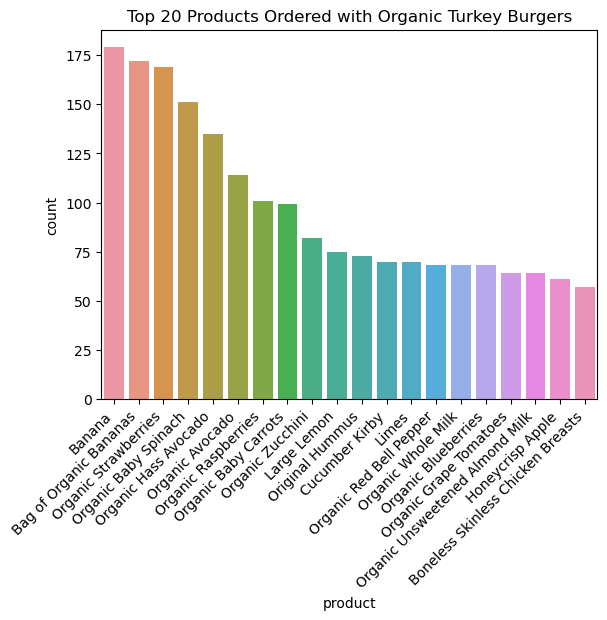

In [73]:
chart_title = "Top 20 Products Ordered with Organic Turkey Burgers"
x_label = "index:O"
y_label = 'count:Q'
pct_of_orders = 'pct_orders:Q'
product_num = 'product_id:O'
multiple = 'purchase_ratio:Q'
sort_list = org_turkey_burger_df['index'].tolist()

fig, ax = plt.subplots()
sns.barplot(org_turkey_burger_df, x= "index", y = "count")
plt.title(chart_title)
plt.xlabel("product")
plt.ylabel("count")
ax.set_xticklabels(org_turkey_burger_list, rotation=45, ha="right")
plt.show()


# Recommendation Algorithm Prototypes

Now we'll look at a few simple ideas for recommendation algorithms. We'll start by using an idea we already explored: finding items that are purchased more frequently than average when a customer purchases a particular item. 

## "Customers Also Purchased" Algorithm

To get started, we'll tweek our "top_n_items" function, so that it finds the top 100 items, but then sorts the items based on how much more often the item is purchased versus the average basket. For instance, if we find that customers that purchase goat cheese are 6 times more likely to purchase mozzarella than the average customer, we make that a top recommendation.

In [74]:
# find top n items ordered with any particular product by product_id
def top_n_recommendations(df, product_id, n):
    orders = df[df['product_id'] == product_id]['order_id'].tolist()
    orders_with_item = df[df['order_id'].isin(orders)]

    # top 30 items ordered with organic strawberries
    num_of_main_item = orders_with_item['product_name'].value_counts()[0]
    top_items_with_item = orders_with_item['product_name'].value_counts()[1:n+1]

    top_items_with_item = pd.DataFrame(top_items_with_item)
    top_items_with_item = top_items_with_item.reset_index()
    top_items_with_item.columns = ['index', 'count']
    top_items_with_item['pct_orders'] = np.round((top_items_with_item['count'] / num_of_main_item) * 100, 2)
    top_items_with_item['product_id'] = top_items_with_item['index'].map(product_dict)
    
    top_items_with_item['pop_pct_orders'] = top_items_with_item['product_id'].map(pct_order_dict)
    top_items_with_item['purchase_ratio'] = np.round(top_items_with_item['pct_orders'] / top_items_with_item['pop_pct_orders'],2)
    
    
    top_items_with_item = top_items_with_item.sort_values(by=['purchase_ratio'], ascending=False)
    top_items_with_item = top_items_with_item[:10]
    top_items_with_item = top_items_with_item.reset_index(drop=True)

    top_items_order_list = top_items_with_item['index'].tolist()
    
    return top_items_with_item

In [82]:
def top_n_rec_viz(df, product_id):
    
    product_name = product_dict_inv[product_id]
    chart_title = "Top 10 Recs based on purchase of " + product_name
    x_label = "index:O"
    y_label = 'purchase_ratio:Q'
    pct_of_orders = 'pct_orders:Q'
    product_num = 'product_id:O'
    multiple = 'purchase_ratio:Q'
    total_orders = 'count:Q'
    sort_list = df['index'].tolist()

    list_ticks = df['index'].tolist()
    
    fig, ax = plt.subplots()
    sns.barplot(df, x= "index", y = "count")
    plt.title(chart_title)
    plt.xlabel("product")
    plt.ylabel("count")
    ax.set_xticklabels(list_ticks, rotation=45, ha="right")
    plt.show()

    return 

### Organic Turkey Burgers

Let's now re-examine our organic turkey burgers. We'll find the 100 items most frequently purchased with the burgers. We'll then recommend the top 10 items (from the top 100) based on how much more likely than average the customer is to purchase that item. 

In [83]:
turkey_recs = top_n_recommendations(df, 23, 100)
turkey_recs

,index,count,pct_orders,product_id,pop_pct_orders,purchase_ratio
0,Grilled Chicken Breast Strips,25,2.34,17878,0.195055,12.00
1,Naturals Chicken Nuggets,30,2.81,2452,0.305810,9.19
2,Organic Chicken Strips,29,2.72,43504,0.324751,8.38
3,Organic Baby Spinach Salad,44,4.12,25931,0.516562,7.98
4,Organic Original Hommus,30,2.81,2825,0.389935,7.21
5,Organic Turkey Bacon,34,3.18,5646,0.447285,7.11
6,Organic Thompson Seedless Raisins,27,2.53,5134,0.363335,6.96
7,Roasted Red Pepper Hummus,35,3.28,21019,0.498029,6.59
8,Organic Chicken & Apple Sausage,26,2.43,9339,0.379763,6.40
9,Organic Snipped Green Beans,33,3.09,13629,0.509283,6.07


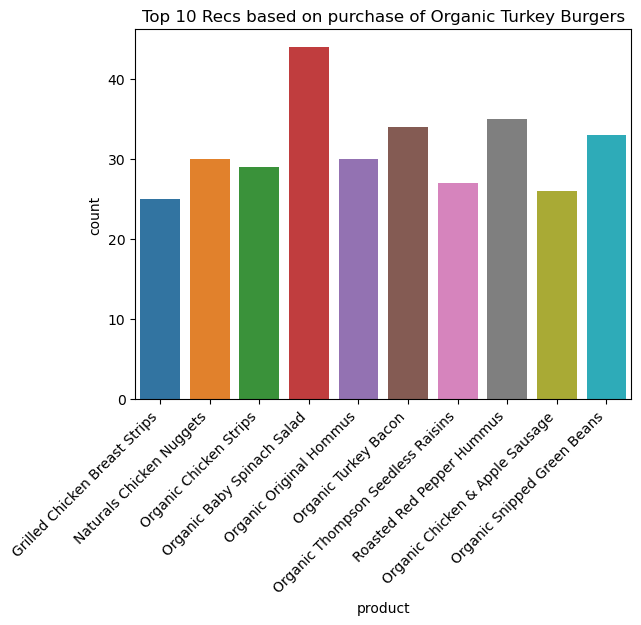

In [84]:
top_n_rec_viz(turkey_recs, 23)

In [85]:
product_dict['Blackberry Cucumber Sparkling Water']

39947

In [86]:
product_dict_inv[39947]

'Blackberry Cucumber Sparkling Water'

### Organic Shredded Mozzarella

In [87]:
mozz_recs = top_n_recommendations(df, 18370, 100)
mozz_recs

,index,count,pct_orders,product_id,pop_pct_orders,purchase_ratio
0,Whole Milk Ricotta Cheese,1156,6.27,2314,0.304991,20.56
1,Pizza Sauce,509,2.76,38288,0.143405,19.25
2,Uncured Pepperoni,626,3.39,37119,0.234136,14.48
3,Organic Shredded Mild Cheddar,584,3.17,781,0.243373,13.03
4,Sliced Black Olives,507,2.75,14462,0.316157,8.70
5,Grated Parmesan,1699,9.21,33731,1.322330,6.96
6,Shredded Parmesan,1307,7.08,4799,1.062967,6.66
7,Organic Chopped Spinach,417,2.26,18918,0.348574,6.48
8,Organic Tomato Sauce,424,2.30,44449,0.397447,5.79
9,Organic Tomato Basil Pasta Sauce,494,2.68,39619,0.491774,5.45


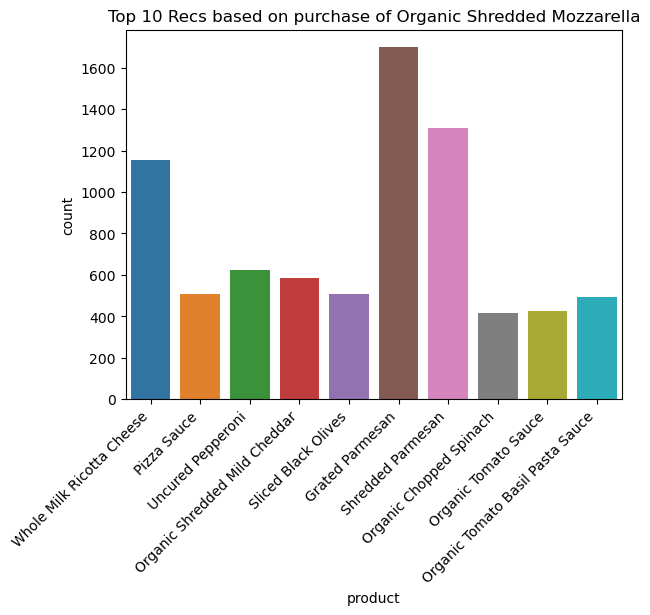

In [88]:
top_n_rec_viz(mozz_recs, 18370)

### Sourdough Bread

In [89]:
bread_recs = top_n_recommendations(df, 21267, 100)
bread_recs

,index,count,pct_orders,product_id,pop_pct_orders,purchase_ratio
0,Salted Butter,419,2.57,35108,0.560144,4.59
1,Sea Salt Pita Chips,353,2.16,31040,0.485986,4.44
2,Organic Creamy Peanut Butter,326,2.00,43713,0.527318,3.79
3,Organic Sour Cream,473,2.90,42701,0.780192,3.72
4,Uncured Genoa Salami,712,4.36,27344,1.212277,3.60
5,Whipped Cream Cheese,532,3.26,42828,0.911758,3.58
6,Sharp Cheddar Cheese,511,3.13,16185,0.881884,3.55
7,Organic Reduced Fat Milk,592,3.63,38689,1.042448,3.48
8,Unsalted Butter,561,3.44,42736,1.042565,3.30
9,Shredded Parmesan,558,3.42,4799,1.062967,3.22


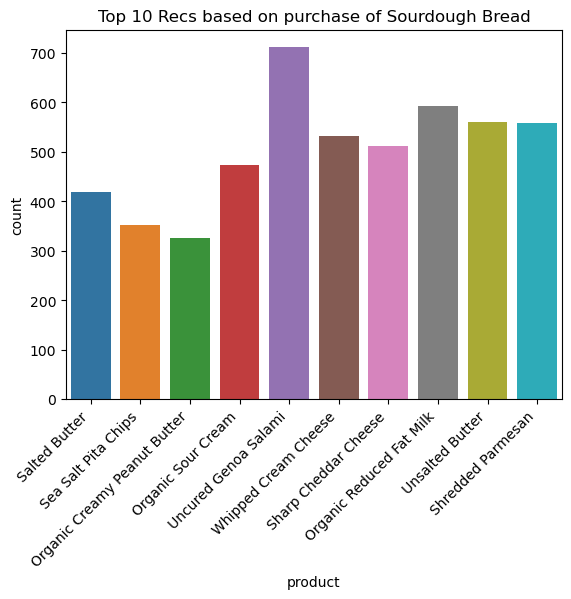

In [90]:
top_n_rec_viz(bread_recs, 21267)

### Lemon Hummus

In [91]:
hummus_recs = top_n_recommendations(df, 13646, 100)
hummus_recs

,index,count,pct_orders,product_id,pop_pct_orders,purchase_ratio
0,Jalapeno Hummus,443,2.69,17429,0.225280,11.94
1,Garlic Hummus,368,2.24,7485,0.239076,9.37
2,Sea Salt Pita Chips,733,4.46,31040,0.485986,9.18
3,Feta Cheese Crumbles,624,3.80,40604,0.945636,4.02
4,Organic Peeled Whole Baby Carrots,1032,6.28,43961,1.618523,3.88
5,Organic Baby Carrots,1340,8.15,42265,2.247709,3.63
6,Organic Baby Rainbow Carrots,331,2.01,32864,0.574058,3.50
7,Organic Whole String Cheese,992,6.03,22035,1.744360,3.46
8,Original Hummus,1174,7.14,30489,2.084545,3.43
9,Whipped Cream Cheese,507,3.08,42828,0.911758,3.38


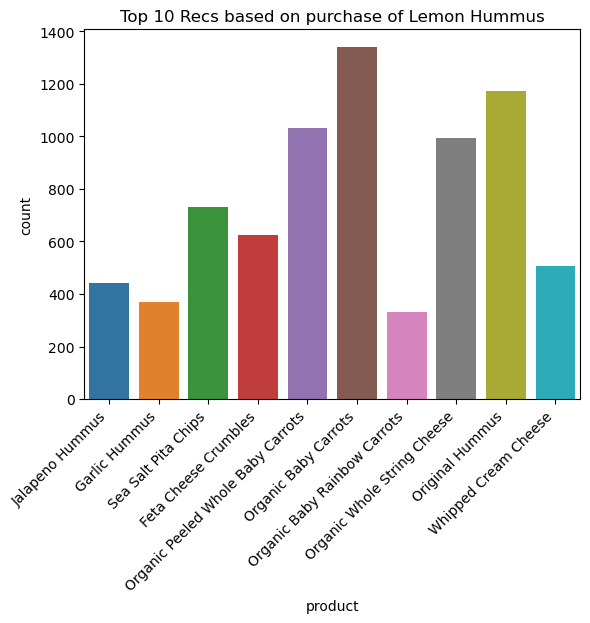

In [92]:
top_n_rec_viz(hummus_recs, 13646)

### Blackberry Cucumber Sparkling Water

In [93]:
bcwater_recs = top_n_recommendations(df, 39947, 100)
bcwater_recs

,index,count,pct_orders,product_id,pop_pct_orders,purchase_ratio
0,Kiwi Sandia Sparkling Water,3160,28.12,12576,0.267401,105.16
1,Curate Melon Pomelo Sparking Water,2389,21.26,45747,0.206075,103.17
2,Pineapple Strawberry Sparkling Water,651,5.79,27275,0.072258,80.13
3,Pineapple Strawberry Naturally Essenced Sparkl...,267,2.38,28342,0.031277,76.10
4,Curate Pomme Baya-Apple Berry Sparkling Water,678,6.03,41682,0.080735,74.69
5,Curate Cherry Lime Sparkling Water,1428,12.71,30353,0.262315,48.45
6,Peach-Pear Sparkling Water,329,2.93,1831,0.084125,34.83
7,Passionfruit Sparkling Water,858,7.64,31964,0.219755,34.77
8,Cran-Raspberry Flavored Sparkling Water,304,2.71,7693,0.112187,24.16
9,Coconut Sparkling Water,263,2.34,12919,0.120254,19.46


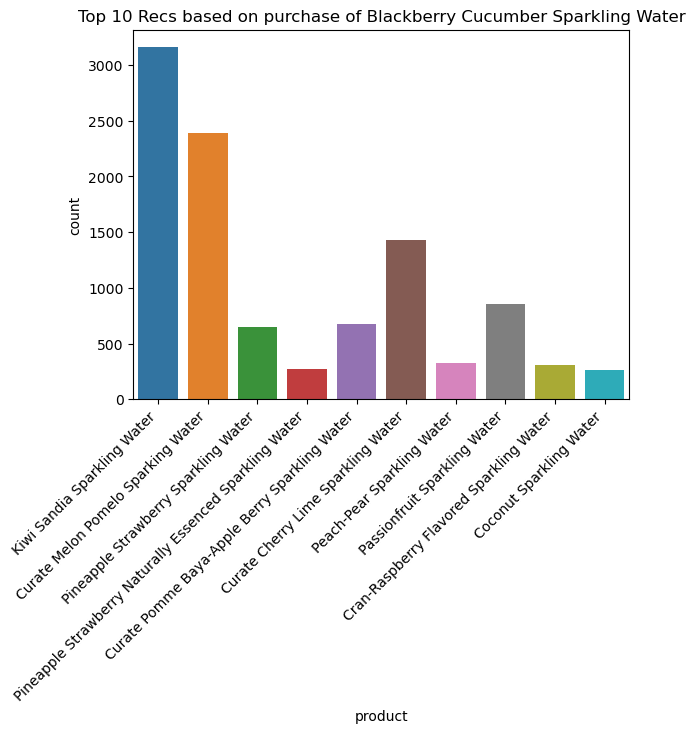

In [94]:
top_n_rec_viz(bcwater_recs, 39947)

## Similar Products (Cosine Similarity)

The next type of algorithm will look also examines item similiarity, but this time we'll use cosine similiarity between all of our items to find the best matches. This is more computationally intensive than our last methodology. I've shrunk the training dataset in order to run this in Pandas, but for a full-scale version, we'd likely run it using a big data platform such as Spark or Dask. 

In [95]:
train.shape

(1384617, 4)

In [96]:
# smaller training dataframe
train_sm = train[:100000].copy()
train_sm.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [97]:
train_sm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   order_id           100000 non-null  int64
 1   product_id         100000 non-null  int64
 2   add_to_cart_order  100000 non-null  int64
 3   reordered          100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [98]:
# create sparse matrix of products and orders
productPivot = train_sm.pivot(index='product_id', columns='order_id', values='reordered')

In [99]:
# fill in all nulls with 0 and all non-null values with 1
productPivot[productPivot.notnull()] = 1
productPivot[productPivot.isnull()] = 0

In [100]:
productPivot.shape

(16738, 9477)

In [101]:
# create our cosine similiartiy matrix
product_sim_matrix = cosine_similarity(productPivot)

In [102]:
# function to find n similar items
def find_similar_items(prod_id, matrix, n):
    
    index_num = np.where(productPivot.index == prod_id)[0][0]
    
    match_list = []
    score_list = []
    
    matrix = matrix[index_num]
    
    for i in range(len(matrix)):
        if matrix[i] > 0.05 and matrix[i] < 0.99:
            match_list.append(i)
            score_list.append(matrix[i])
            
    order_match_list = productPivot[productPivot.reset_index().index.isin(match_list)].index.values.tolist()
      
    df = products[products['product_id'].isin(order_match_list)].copy()
    df['sim_score'] = score_list
    df = df.sort_values(by=['sim_score'], ascending=False)
    df = df[:n]
    
    return df

### Chocolate Sandwich Cookies

Let's first test this out on the first item in our product table: "Chocalate Sandwich Cookies"

In [103]:
# similarity to chocolate sandwich cookies
find_similar_items(1, product_sim_matrix, 10)

,product_id,product_name,aisle_id,department_id,count,count_bin,sim_score
29872,29873,Morena Pure Cane Sugar,17,13,189,101-500,0.447214
8235,8236,Imported Italian Peeled Tomatoes,81,15,124,101-500,0.447214
10961,10962,Extra Strength Energy Shot,64,7,142,101-500,0.447214
13680,13681,Pure Mint With Herbal Accent Sugar Free Gum,46,19,89,51-100,0.316228
37599,37600,Organic Kettle Corn,23,19,243,101-500,0.316228
35893,35894,Moisturizing Lotion,127,11,710,501-2500,0.316228
30663,30664,Organic Beef Base,69,15,856,501-2500,0.258199
30776,30777,Organic Classic Hummus,67,20,1273,501-2500,0.223607
21768,21769,Chunky Guacamole,67,20,2609,2500-10000,0.223607
45228,45229,Organic Chia Seeds,117,19,657,501-2500,0.223607


The algorithm seems to provide reasonable results, recommending items such as peanut butter cookies, Ritz crackers, and rice sea salt & pepper snacks. However, some results seem odd, such as coleslaw and cara cara oranges. It the algorithm uncovering a deeper connection or is it simply giving us random noise?

### Organic Turkey Burgers

Next, let's take another look at our organic turkey burgers

In [104]:
# organic turkey burgers
find_similar_items(23, product_sim_matrix, 10)

,product_id,product_name,aisle_id,department_id,count,count_bin,sim_score
16306,16307,Crystal Deodorant Stone,80,11,25,21-50,0.577350
32332,32333,Apple + Banana Fruit Bar,3,19,220,101-500,0.577350
24582,24583,Organic Unsweetened & Salt Free Sunflower See...,88,13,1270,501-2500,0.577350
46983,46984,Organic Coconut Spread,91,16,1416,501-2500,0.408248
46324,46325,Original Sparkling Water,115,7,693,501-2500,0.408248
44615,44616,Chlorine Free Maxi Overnight Feminine Pads,126,11,332,101-500,0.408248
25019,25020,Organic Banana Chips,50,19,1223,501-2500,0.333333
43672,43673,Organic Tellicherry Black Peppercorns,104,13,914,501-2500,0.333333
35832,35833,Andouille Chicken & Turkey Sausage,106,12,770,501-2500,0.333333
35262,35263,Himalayan Pink Salt,104,13,1368,501-2500,0.288675


This algorithm provides much different recommendations. Items it suggests purchasing include whole milk greek yogurt (plain), original sparkling water, and sunflower seed oil. My initial view of this is skepticism; however, the algorithm may perform better using the full training dataset, as sparse matrices need a very large volume of data to be workable. 

### Organic Shredded Mozzarella

In [105]:
# Organic Shredded Mozzarella
find_similar_items(18370, product_sim_matrix, 10)

,product_id,product_name,aisle_id,department_id,count,count_bin,sim_score
73,74,Artisan Chick'n & Apple Sausage,14,20,180,101-500,0.160128
35520,35521,Mountain Spring Long Lasting Deodorant for Men,80,11,155,101-500,0.160128
10250,10251,Africa Single Origin 1 Coffee,26,7,448,101-500,0.160128
10435,10436,"Granola, Original Honey",57,14,273,101-500,0.160128
44523,44524,Organic Baby Food Fruit Mashup Green Kale & Ap...,92,18,135,101-500,0.160128
11650,11651,Chorizo Style,14,20,204,101-500,0.160128
39502,39503,Cherry Jel Dessert,105,13,33,21-50,0.160128
37449,37450,Falafel Balls,13,20,99,51-100,0.160128
36347,36348,Organic Baby Food Fruit Mashup Mama Bear Blueb...,92,18,95,51-100,0.160128
13845,13846,Thai Basil & Sweet Chili Medium Stir-Fry Sauce,66,6,20,6-20,0.160128


Similar to the cookies, the recommendations for mozzarella sometimes seem reasonable and sometimes seem off-the-wall. Margherita pizza might be a good recommendation here, but "Mountain Spring Long Lasting Deodorant for Men" seems like a bit of a stretch. Even if men are more likely to purchase mozzarella than women, men's deodorant does not pass "the common sense" test on good recommendations for customers buying mozzarella. 

### Sourdough Bread

In [106]:
find_similar_items(21267, product_sim_matrix, 10)

,product_id,product_name,aisle_id,department_id,count,count_bin,sim_score
26511,26512,Sausage Cuts Real Beef Treats,40,8,80,51-100,0.194257
17201,17202,Bologna Style Veggie Protein Slices,14,20,142,101-500,0.137361
28761,28762,Window Cleaner with Vinegar,114,17,288,101-500,0.137361
12113,12114,"Buffalo Meat Bar with Cranberries, Apple & Ora...",23,19,33,21-50,0.137361
42051,42052,Lavender Hand Sanitizer,109,11,347,101-500,0.137361
4484,4485,Cinnamon Raisin Granola,57,14,426,101-500,0.137361
11002,11003,Original Recipe Scones Mix,130,14,52,51-100,0.137361
42233,42234,Coffee Cold Brew Fs W Mcts,26,7,443,101-500,0.137361
10998,10999,Organic Lemon Thyme,16,4,206,101-500,0.137361
34090,34091,Medium Guajillo Roasted Garlic & Tomatillo Salsa,51,13,209,101-500,0.137361


### Lemon Hummus

In [107]:
find_similar_items(13646, product_sim_matrix, 10)

,product_id,product_name,aisle_id,department_id,count,count_bin,sim_score
25534,25535,Organic Creamy Peanut Butter Hint of Sea Salt,88,13,535,501-2500,0.164399
30034,30035,Natural Sweetener,17,13,569,501-2500,0.164399
15082,15083,Hommus Sundried Tomato & Basil,51,13,216,101-500,0.164399
16406,16407,Rosemary Croccantini,78,19,89,51-100,0.164399
17420,17421,Coconut Mango Chia Vitality Beverage,31,7,416,101-500,0.164399
17434,17435,Original California Style Hot Sauce,5,13,328,101-500,0.164399
17605,17606,Premium Chocolate Powdered Peanut Butter,88,13,299,101-500,0.164399
19555,19556,Sesame Gruyere Cheese Crisps,78,19,56,51-100,0.164399
21889,21890,"Milk, Low Fat, 1% Milkfat",84,16,609,501-2500,0.164399
25024,25025,Rye Style Bread,58,1,401,101-500,0.164399


### Blackberry Cucumber Sparkling Water

In [108]:
find_similar_items(39947, product_sim_matrix, 10)

,product_id,product_name,aisle_id,department_id,count,count_bin,sim_score
49586,49587,Tender Beef & Liver Feast Classic Wet Cat Food,41,8,316,101-500,0.176777
28389,28390,Chicken Meat with Currant & Sesame BBQ Seasoning,3,19,416,101-500,0.176777
15903,15904,Mandarin Orange & Grapefruit Hand Wash 12 oz,25,11,479,101-500,0.176777
40139,40140,Raw Probiotic Drink Gut Shot Smoked Jalapeno,81,15,99,51-100,0.176777
15082,15083,Hommus Sundried Tomato & Basil,51,13,216,101-500,0.176777
27040,27041,Mushroom Stems & Pieces,81,15,113,101-500,0.176777
8875,8876,"8\"" Pumpkin Pie",8,3,86,51-100,0.176777
39873,39874,Porter & Spicy Brown Mustard,72,13,114,101-500,0.176777
14716,14717,Parchment Large Baking Cups - 60 CT,97,13,120,101-500,0.176777
10037,10038,Hamburger Oval Dill Pickle Chips,110,13,206,101-500,0.176777


The sparkling water recommendations seem more reasonable than some of the others. Here we find that customers purchasing blackberry cucumber sparkling water would be recommended items like "Curate Melon Pomelo Sparkling Water" and "Kiwi Sandia Sparkling Water." There's even some variety with "Mighty Dry Hard Cider." Nevertheless, there are once again some odd recommendations included including dishwasher detergent and cat food. Interestingly, both the detergent and cat food are not frequentliy purchased items, so perhaps the algorithm would work better with more data that might filter out obscure items such as these. 

## Similar Baskets (Cosine Similiarity)

Our final approach will be to look at cosine similiarity once again, but this time, we'll do it on an order / basket basis. Instead of analyzing product similiarity, we are thus analyzing "market basket similiarity" and recommending products that have come from similiar baskets. 

In [109]:
train_200k = train[:200000].copy()

In [110]:
orderPivot = train_200k.pivot(index='order_id', columns='product_id', values='reordered')

In [111]:
orderPivot[orderPivot.notnull()] = 1
orderPivot[orderPivot.isnull()] = 0

In [112]:
orderPivot.shape

(18926, 22311)

In [113]:
order_sim_matrix = cosine_similarity(orderPivot)

In [114]:
def find_similar_baskets(matrix):
    match_list = []

    for i in range(len(matrix)):
        if matrix[i] > 0.1 and matrix[i] < 0.99:
            match_list.append(i)
            
    order_match_list = orderPivot[orderPivot.reset_index().index.isin(match_list)].index.values.tolist()
    
    return order_match_list

In [115]:
# def find_similar_baskets(order_id):
#     match_list = []

#     for i in range(len(matrix)):
#         if matrix[i] > 0.2 and matrix[i] < 0.99:
#             match_list.append(i)
            
#     order_match_list = orderPivot[orderPivot.reset_index().index.isin(match_list)].index.values.tolist()
    
#     return order_match_list

In [116]:
matched_baskets = find_similar_baskets(order_sim_matrix[0])

### Sample Basket

In [117]:
sample_order = train_sm[train_sm['order_id']==36].copy()
sample_order['product_name'] = sample_order['product_id'].map(product_dict_inv)
sample_order

,order_id,product_id,add_to_cart_order,reordered,product_name
8,36,39612,1,0,Grated Pecorino Romano Cheese
9,36,19660,2,1,Spring Water
10,36,49235,3,0,Organic Half & Half
11,36,43086,4,1,Super Greens Salad
12,36,46620,5,1,Cage Free Extra Large Grade AA Eggs
13,36,34497,6,1,"Prosciutto, Americano"
14,36,48679,7,1,Organic Garnet Sweet Potato (Yam)
15,36,46979,8,1,Asparagus


In [118]:
sample_order_list = sample_order['product_id'].tolist()
sample_order_list

[39612, 19660, 49235, 43086, 46620, 34497, 48679, 46979]

In [119]:
matching_vals = pd.DataFrame(train_sm[train_sm['order_id'].isin(matched_baskets)]['product_id'].value_counts())
matching_vals = matching_vals.reset_index()
matching_vals.columns = ['product_id', 'count']
matching_vals['product_name'] = matching_vals['product_id'].map(product_dict_inv)
matching_vals[matching_vals['product_id'].isin(sample_order_list) == False][:10]

,product_id,count,product_name
0,13176,736,Bag of Organic Bananas
1,47209,340,Organic Hass Avocado
2,21137,150,Organic Strawberries
3,21903,116,Organic Baby Spinach
4,49683,90,Cucumber Kirby
5,27966,87,Organic Raspberries
6,22035,84,Organic Whole String Cheese
7,27845,63,Organic Whole Milk
8,30391,60,Organic Cucumber
9,5876,60,Organic Lemon


### Another Sample

In [120]:
matched_baskets2 = find_similar_baskets(order_sim_matrix[10])

In [121]:
sample_order2 = train_sm[train_sm['order_id']==878].copy()
sample_order2['product_name'] = sample_order2['product_id'].map(product_dict_inv)
sample_order2

,order_id,product_id,add_to_cart_order,reordered,product_name
195,878,48070,1,1,Chocolate Mint Crisp Protein Bar
196,878,24852,2,1,Banana
197,878,23044,3,0,Cream Top Smooth & Creamy Vanilla Yogurt
198,878,45066,4,1,Honeycrisp Apple
199,878,21903,5,1,Organic Baby Spinach
200,878,24964,6,0,Organic Garlic
201,878,47209,7,1,Organic Hass Avocado
202,878,40706,8,0,Organic Grape Tomatoes
203,878,21616,9,0,Organic Baby Arugula
204,878,10305,10,0,Black Plum


In [122]:
sample_order_list2 = sample_order2['product_id'].tolist()
# sample_order_list2

In [123]:
matching_vals2 = pd.DataFrame(train_sm[train_sm['order_id'].isin(matched_baskets2)]['product_id'].value_counts())
matching_vals2 = matching_vals2.reset_index()
matching_vals2.columns = ['product_id', 'count']
matching_vals2['product_name'] = matching_vals2['product_id'].map(product_dict_inv)
matching_vals2[matching_vals2['product_id'].isin(sample_order_list2) == False][:10]
# matching_vals2

,product_id,count,product_name
0,16797,249,Strawberries
1,12341,124,Hass Avocados
2,13176,75,Bag of Organic Bananas
3,6184,73,Clementines
5,43352,42,Raspberries
7,39275,32,Organic Blueberries
8,32403,27,Fat Free Skim Milk
10,21288,20,Blackberries
11,13424,20,Almonds
12,12078,19,Shredded Mexican Blend Cheese


Overall, I'm not a fan of this methodology. It seems to recommend frequently purchased items too often and none of the recommendations seem very specifically tailored to the customer. 

# Final Recommendations

Based on this analysis, my recommendation is to use the "customers also purchased" algorithm, which seems to emphasize the most relevant items for the customer. We might also expand the item-based cosine-similiarity algorithm to the full training set and see if our predictions improve. 

We could test both algorithms out on random sets of customers and see if customers favored one or the other based on "additional purchases from recommendations" and "customer engagement with recommendations."